<a href="https://colab.research.google.com/github/AvantiShri/colab_notebooks/blob/master/Combined_Regression_Classification_CTCF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import division, print_function

In [2]:
!pip install pyfasta
!pip install deeptools
!pip install momma_dragonn

!apt-get install bedtools

#Download optimal IDR thresholded peaks
![[ -f idr_optimal_file.narrowPeak.gz ]] || wget https://www.encodeproject.org/files/ENCFF519CXF/@@download/ENCFF519CXF.bed.gz -O idr_optimal_file.narrowPeak.gz
  
#Get hg38 fasta by download 2bit and then converting to fa
![[ -f hg38.2bit ]] || wget http://hgdownload.cse.ucsc.edu/goldenPath/hg38/bigZips/hg38.2bit -O hg38.2bit  
![[ -f twoBitToFa ]] || wget http://hgdownload.soe.ucsc.edu/admin/exe/linux.x86_64/twoBitToFa -O twoBitToFa
!chmod a+x twoBitToFa
![[ -f hg38.genome.fa ]] || ./twoBitToFa hg38.2bit hg38.genome.fa
  
#download hg38 chromsizes file
![[ -f hg38.chrom.sizes ]] || wget http://hgdownload.cse.ucsc.edu/goldenPath/hg38/bigZips/hg38.chrom.sizes -O hg38.chrom.sizes

Reading package lists... Done
Building dependency tree       
Reading state information... Done
bedtools is already the newest version (2.26.0+dfsg-5).
0 upgraded, 0 newly installed, 0 to remove and 5 not upgraded.


In [0]:
#do an asinh transform of column 7 (SPP singal strength)
!zcat idr_optimal_file.narrowPeak.gz | perl -lane 'BEGIN{use Math::Trig} {print $F[0]."\t".(($F[1]+$F[9]))."\t".(($F[1]+$F[9]))."\t".asinh($F[6])}' | bedtools slop -g hg38.chrom.sizes -b 500 | perl -lane 'if ($F[2]-$F[1]==1000) {print $F[0]."\t".$F[1]."\t".$F[2]."\t$F[3]"}' | sortBed | gzip -c > positives_asinh_spp.gz
#hold out chr22 for validation and 1,8 & 21 for testing
!zcat positives_asinh_spp.gz | egrep -w 'chr1|chr8|chr21' | gzip -c > test_positives_asinh_spp.gz
!zcat positives_asinh_spp.gz | egrep -w 'chr22' | gzip -c > valid_positives_asinh_spp.gz
!zcat positives_asinh_spp.gz | egrep -w -v 'chr1|chr8|chr21|chr22' | gzip -c > train_positives_asinh_spp.gz

In [4]:
import keras
from keras.models import Model
from momma_dragonn.data_loaders import pyfasta_data_loader
import six
from scipy.stats import spearmanr
import numpy as np


def get_single_stream_data_generator(bed_source, batch_size):

  return pyfasta_data_loader.SingleStreamSeqOnly(
               batch_size=batch_size,
               bed_source=bed_source,
               fasta_data_source="hg38.genome.fa",
               rc_augment=True,
               num_to_load_for_eval=100, #not used
               labels_dtype="float",
               wrap_in_keys=["sequence", "output"],
               randomize_after_pass=True)


def get_core_model(num_conv_filters,
                   conv_filter_length,
                   pool_length_and_stride,
                   num_dense_units):
  input = keras.layers.Input(shape=(1000,4), name="sequence")
  conv1 = keras.layers.convolutional.Conv1D(
              filters=num_conv_filters, kernel_size=conv_filter_length,
              padding="same")(input)
  conv1relu = keras.layers.core.Activation(activation="relu")(conv1)
  conv2 = keras.layers.convolutional.Conv1D(
              filters=num_conv_filters,
              kernel_size=conv_filter_length,
              padding="same")(conv1relu)
  conv2relu = keras.layers.core.Activation(activation="relu")(conv2)
  conv3 = keras.layers.convolutional.Conv1D(
              filters=num_conv_filters,
              kernel_size=conv_filter_length,
              padding="same")(conv2relu)
  conv3relu = keras.layers.core.Activation(activation="relu")(conv3)
  avgpool = keras.layers.convolutional.AveragePooling1D(
                pool_size=pool_length_and_stride,
                strides=pool_length_and_stride)(conv3relu)
  flatten = keras.layers.core.Flatten()(avgpool)
  dense1 = keras.layers.core.Dense(units=num_dense_units[0])(flatten)
  dense1relu = keras.layers.core.Activation(activation="relu")(dense1)
  
  return (input, dense1relu)


def train_positivesonly_regression_model(num_outputs,
                           train_bed_source,
                           valid_bed_source,
                           num_validation_samples,
                           steps_per_epoch=200,
                           batch_size=128,
                           adam_lr=0.001,
                           num_conv_filters=15,
                           conv_filter_length=15,
                           pool_length_and_stride=5,
                           num_dense_units=[100],
                           preinit_model=None,
                           epochs_to_train_for=60):
  
  validation_steps = int(np.ceil(num_validation_samples/batch_size))
  
  
  class SpearmanCorrCallback(keras.callbacks.Callback):
    
    def __init__(self, validation_steps, valid_data_generator):
      self.validation_steps = validation_steps
      self.valid_data_generator = valid_data_generator
  
    def on_epoch_end(self, epoch, logs):
      valid_data_preds = []
      valid_data_labels = []
      for batch_num in range(self.validation_steps):
        (X_batch, y_batch) = six.next(self.valid_data_generator)
        valid_data_labels.extend(y_batch["output"])
        valid_data_preds.extend(self.model.predict(X_batch))
      valid_data_preds = np.array(valid_data_preds)
      valid_data_labels = np.array(valid_data_labels)
      
      print(spearmanr(a=valid_data_labels[:,0],
                      b=valid_data_preds[:,0]))
      
  
  if (preinit_model is None):
    
    (input,dense1relu) = get_core_model(
        num_conv_filters=num_conv_filters,
        conv_filter_length=conv_filter_length,
        pool_length_and_stride=pool_length_and_stride,
        num_dense_units=num_dense_units)
    output = keras.layers.core.Dense(units=num_outputs,
                                     name="output")(dense1relu)
    model = Model(inputs=[input], outputs=[output])
    model.compile(optimizer=keras.optimizers.Adam(lr=adam_lr),
                  loss={"output": "mse"})
  else:
    model = preinit_model
  
  model.summary()
  early_stopping_callback = keras.callbacks.EarlyStopping(
                              monitor='val_loss',
                              patience=epochs_to_train_for,
                              restore_best_weights=True)
  fit_history = model.fit_generator(
    generator=get_single_stream_data_generator(
      bed_source=train_bed_source,
      batch_size=batch_size).get_batch_generator(),
    validation_data= get_single_stream_data_generator(
      bed_source=valid_bed_source,
      batch_size=batch_size).get_batch_generator(),
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    epochs=epochs_to_train_for,
    callbacks=[early_stopping_callback,
               #Need to have two separate generators for the callback and
               # for the main training method to keep keras happy
               SpearmanCorrCallback(
                   valid_data_generator=get_single_stream_data_generator(
                      bed_source=valid_bed_source,
                      batch_size=batch_size).get_batch_generator(),
                   validation_steps=validation_steps)]
  )
  #the callback isn't triggered if the upper epoch limit is hit,
  # so make sure the set the weights from the best epoch at the end
  model.set_weights(early_stopping_callback.best_weights)
  
  return model, fit_history

Using TensorFlow backend.


In [5]:
from matplotlib import pyplot as plt
from keras.models import load_model

#positives_asinh_spp_model, positives_asinh_spp_fit_history = train_positivesonly_regression_model(
#                             num_outputs=1,
#                             num_validation_samples=sum([1 for x in gzip.open("valid_positives_asinh_spp.gz",'rb')]),
#                             train_bed_source="train_positives_asinh_spp.gz",
#                             valid_bed_source="valid_positives_asinh_spp.gz")

#from matplotlib import pyplot as plt
#plt.plot(list(range(len(positives_asinh_spp_fit_history.history['loss']))),
#         positives_asinh_spp_fit_history.history['loss'])
#plt.plot(list(range(len(positives_asinh_spp_fit_history.history['val_loss']))),
#         positives_asinh_spp_fit_history.history['val_loss'])
#plt.show()
#print("Best valid epoch:",np.argmin(positives_asinh_spp_fit_history.history['val_loss'])+1)

#Save the model
#from google.colab import drive
#drive.mount('/content/gdrive')
#%cd /content/gdrive/"My Drive"/colab_notebook_data/regression_experiments/K562/CTCF/ENCFF519CXF
#positives_asinh_spp_model.save("positives_asinh_spp_model_2018Nov28_0908am_chromosomeholdout.h5")
#%cd /content

#Load the model
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/"My Drive"/colab_notebook_data/regression_experiments/K562/CTCF/ENCFF519CXF
positives_asinh_spp_model = load_model("positives_asinh_spp_model_2018Nov28_0908am_chromosomeholdout.h5")
%cd /content

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/colab_notebook_data/regression_experiments/K562/CTCF/ENCFF519CXF
/content


In [6]:
import os
import sys
import gzip
from collections import OrderedDict

def tile_across_genome(chrom_sizes_file,
                       chroms_to_exclude,
                       out_file, bin_sizes,
                       bin_stride):

    chromosome_sizes = OrderedDict()
    for line in open(chrom_sizes_file):
        chrom, size = line.rstrip().split("\t")
        if (("_" not in chrom) and
            (chrom not in chroms_to_exclude)):
            size = int(size)
            chromosome_sizes[chrom] = size 
        else:
            pass
            #print("Dropping chrom",chrom)

    outfile = open(out_file, "w")
    
    for a_chrom in chromosome_sizes:
        the_end = chromosome_sizes[a_chrom] 
        bin_start = 0
        while ((bin_start + bin_sizes) < the_end):
            outfile.write(a_chrom+"\t"+str(bin_start)
                          +"\t"+str(bin_start+bin_sizes)+"\n")
            bin_start += bin_stride

    outfile.close()

if (os.path.isfile("1kb_tiles.bed")==False):
  print("Tiling across the genome in 1kb windows")
  tile_across_genome(out_file = "1kb_tiles.bed",
                     chrom_sizes_file="hg38.chrom.sizes",
                     bin_sizes=1000,
                     bin_stride=1000,
                     chroms_to_exclude=["chrM"])    
    
# Positive set: 1kb around IDR-optimal peaks
![[ -f positive_regions.gz ]] || zcat idr_optimal_file.narrowPeak.gz | perl -lane 'print $F[0]."\t".(($F[1]+$F[9]))."\t".(($F[1]+$F[9]))' | bedtools slop -g hg38.chrom.sizes -b 500 | perl -lane 'if ($F[2]-$F[1]==1000) {print $F[0]."\t".$F[1]."\t".$F[2]."\t1"}' | sortBed | gzip -c > positive_regions.gz
# Negative set: 1kb regions tiling across the genome that do not overlap any of the peaks in the idr file
![[ -f negative_regions.gz ]] || bedtools intersect -sorted -v -a 1kb_tiles.bed -b  positive_regions.gz -wa | perl -lane 'print $F[0]."\t".$F[1]."\t".$F[2]."\t0"' | gzip -c > negative_regions.gz
#Put positive and negative set together into "binary_labels.gz"
![[ -f binary_labels.gz ]] || zcat positive_regions.gz negative_regions.gz | sortBed | gzip -c > binary_labels.gz

Tiling across the genome in 1kb windows


In [0]:
#prepare binary labels
!zcat binary_labels.gz | egrep -w 'chr1|chr8|chr21' | gzip -c > test_binary_labels.gz
!zcat binary_labels.gz | egrep -w 'chr22' | gzip -c > valid_binary_labels.gz
!zcat valid_binary_labels.gz | perl -lane 'if ($F[3]==1) {print $_}' | gzip -c > positives_valid_binary_labels.gz
!zcat valid_binary_labels.gz | perl -lane 'if ($F[3]==0) {print $_}' | gzip -c > negatives_valid_binary_labels.gz
!zcat binary_labels.gz | egrep -w -v 'chr1|chr8|chr21|chr22' | gzip -c > train_binary_labels.gz
!zcat train_binary_labels.gz | perl -lane 'if ($F[3]==1) {print $_}' | gzip -c > positives_train_binary_labels.gz
!zcat train_binary_labels.gz | perl -lane 'if ($F[3]==0) {print $_}' | gzip -c > negatives_train_binary_labels.gz

In [8]:
#train a normal binary prediction model
from sklearn.metrics import roc_auc_score, average_precision_score

def get_two_stream_data_generator(positives_bed_source,
                                  negatives_bed_source,
                                  negatives_to_positives_ratio,
                                  batch_size):

  return pyfasta_data_loader.TwoStreamSeqOnly(batch_size=batch_size,
                          positives_bed_source=positives_bed_source,
                          negatives_bed_source=negatives_bed_source,
                          negatives_to_positives_ratio=negatives_to_positives_ratio,
                          fasta_data_source="hg38.genome.fa",
                          rc_augment=True,
                          num_to_load_for_eval=100, #Not used
                          randomize_after_pass=True,
                          stratification_settings=None,
                          random_seed=1,
                          labels_dtype="float",
                          wrap_in_keys=["sequence", "output"],
                          append_chrom_number=False)

def train_binary_classification_model(
    num_outputs,
    positives_train_bed_source,
    negatives_train_bed_source,
    positives_valid_bed_source,
    negatives_valid_bed_source,
    negatives_to_positives_ratio,
    num_validation_samples,
    steps_per_epoch=200,
    batch_size=128,
    adam_lr=0.001,
    num_conv_filters=15,
    conv_filter_length=15,
    pool_length_and_stride=5,
    num_dense_units=[100],
    preinit_model=None,
    epochs_to_train_for=60):
  
  validation_steps = int(np.ceil(num_validation_samples/batch_size))
  
  
  class BinaryClassificationCallback(keras.callbacks.Callback):
    
    def __init__(self, validation_steps, valid_data_generator):
      self.validation_steps = validation_steps
      self.valid_data_generator = valid_data_generator
  
    def on_epoch_end(self, epoch, logs):
      valid_data_preds = []
      valid_data_labels = []
      for batch_num in range(self.validation_steps):
        (X_batch, y_batch) = six.next(self.valid_data_generator)
        valid_data_labels.extend(y_batch["output"])
        valid_data_preds.extend(self.model.predict(X_batch))
      valid_data_preds = np.array(valid_data_preds)
      valid_data_labels = np.array(valid_data_labels)
      
      print("auROC:",roc_auc_score(y_true=valid_data_labels[:,0],
                                   y_score=valid_data_preds[:,0]))
      print("auPRC:",average_precision_score(y_true=valid_data_labels[:,0],
                                             y_score=valid_data_preds[:,0]))
      
  
  if (preinit_model is None):
    
    (input,dense1relu) = get_core_model(
        num_conv_filters=num_conv_filters,
        conv_filter_length=conv_filter_length,
        pool_length_and_stride=pool_length_and_stride,
        num_dense_units=num_dense_units)
    output_preact = keras.layers.core.Dense(units=num_outputs)(dense1relu)
    output = keras.layers.core.Activation("sigmoid", name="output")(output_preact)
    model = Model(inputs=[input], outputs=[output])
    model.compile(optimizer=keras.optimizers.Adam(lr=adam_lr),
                  loss={"output": "binary_crossentropy"})
  else:
    model = preinit_model
  
  model.summary()
  early_stopping_callback = keras.callbacks.EarlyStopping(
                              monitor='val_loss',
                              patience=epochs_to_train_for,
                              restore_best_weights=True)
  fit_history = model.fit_generator(
    generator=get_two_stream_data_generator(
      positives_bed_source=positives_train_bed_source,
      negatives_bed_source=negatives_train_bed_source,
      negatives_to_positives_ratio=negatives_to_positives_ratio,
      batch_size=batch_size).get_batch_generator(),
    validation_data=get_two_stream_data_generator(
      positives_bed_source=positives_valid_bed_source,
      negatives_bed_source=negatives_valid_bed_source,
      negatives_to_positives_ratio=negatives_to_positives_ratio,
      batch_size=batch_size).get_batch_generator(),
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    epochs=epochs_to_train_for,
    callbacks=[early_stopping_callback,
               #Need to have two separate generators for the callback and
               # for the main training method to keep keras happy
               BinaryClassificationCallback(
                   valid_data_generator=get_two_stream_data_generator(
                      positives_bed_source=positives_valid_bed_source,
                      negatives_bed_source=negatives_valid_bed_source,
                      negatives_to_positives_ratio=negatives_to_positives_ratio,
                      batch_size=batch_size).get_batch_generator(),
                   validation_steps=validation_steps)]
  )
  #the callback isn't triggered if the upper epoch limit is hit,
  # so make sure the set the weights from the best epoch at the end
  model.set_weights(early_stopping_callback.best_weights)
  
  return model, fit_history

binary_model, binary_fit_history = train_binary_classification_model(
         adam_lr=0.001,
         num_outputs=1,
         num_validation_samples=5000,
         positives_train_bed_source="positives_train_binary_labels.gz",
         negatives_train_bed_source="negatives_train_binary_labels.gz",
         positives_valid_bed_source="positives_valid_binary_labels.gz",
         negatives_valid_bed_source="negatives_valid_binary_labels.gz",
         negatives_to_positives_ratio=9)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence (InputLayer)        (None, 1000, 4)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1000, 15)          915       
_________________________________________________________________
activation_1 (Activation)    (None, 1000, 15)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1000, 15)          3390      
_________________________________________________________________
activation_2 (Activation)    (None, 1000, 15)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1000, 15)          3390      
_________________________________________________________________
activation_3 (Activation)    (None, 1000, 15)          0         
__________

In [11]:
#Save the model
#from google.colab import drive
#drive.mount('/content/gdrive')
#%cd /content/gdrive/"My Drive"/colab_notebook_data/regression_experiments/K562/CTCF/ENCFF519CXF
#binary_model.save("binary_model_2018Nov29_0450pm_notnanfree.h5")
#%cd /content

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/colab_notebook_data/regression_experiments/K562/CTCF/ENCFF519CXF
/content


In [0]:
from keras.models import Model

binary_preact_model = Model(inputs=binary_model.layers[0].input,
                            outputs=binary_model.layers[-2].output)

In [17]:
from collections import OrderedDict
import numpy as np

def iterate_over_generator_in_batches(batch_size, generator):
  X_batch = []
  y_batch = []
  for (X_ex, y_ex, coor, fastastr) in generator:
    X_batch.append(X_ex)
    y_batch.append(y_ex)
    if (len(X_batch)==batch_size):
      yield np.array(X_batch), np.array(y_batch)
      X_batch = []
      y_batch = []
  if (len(X_batch) > 0):
    yield np.array(X_batch), np.array(y_batch)
    
def get_predictions_and_true_labels(bed_source, name_to_model): 
  generator = pyfasta_data_loader.SingleStreamSeqOnly(
     batch_size=None,
     bed_source=bed_source,
     fasta_data_source="hg38.genome.fa",
     rc_augment=True,
     num_to_load_for_eval=None, #not used
     labels_dtype="float",
     wrap_in_keys=["sequence", "output"],
     randomize_after_pass=False).get_generator(loop_infinitely=False)  
  name_to_predictions = OrderedDict()
  true_y = []
  for X_batch, y_batch in iterate_over_generator_in_batches(
                            batch_size=200, generator=generator):
    true_y.extend(y_batch)
    for name in name_to_model:
      if name not in name_to_predictions:
        name_to_predictions[name] = []
      name_to_predictions[name].extend(name_to_model[name].predict(
                                       {'sequence': X_batch}))
  for name in name_to_predictions:
    name_to_predictions[name] = np.array(name_to_predictions[name])
  return np.array(true_y), name_to_predictions
    
positives_asinh_spp_name_to_model = {'positives_asinh_spp_model': positives_asinh_spp_model,
                                     'binary_preact_model': binary_preact_model}


#verify no train-test contamination!
!bedtools intersect -sorted -a test_positives_asinh_spp.gz -b train_positives_asinh_spp.gz | wc -l
!bedtools intersect -sorted -a valid_positives_asinh_spp.gz -b train_positives_asinh_spp.gz | wc -l
!bedtools intersect -sorted -a test_positives_asinh_spp.gz -b valid_positives_asinh_spp.gz | wc -l

test_positives_asinh_spp_y, test_positives_asinh_spp_name_to_predictions = get_predictions_and_true_labels(
    bed_source="test_positives_asinh_spp.gz",
    name_to_model=positives_asinh_spp_name_to_model)
train_positives_asinh_spp_y, train_positives_asinh_spp_name_to_predictions = get_predictions_and_true_labels(
    bed_source="train_positives_asinh_spp.gz",
    name_to_model=positives_asinh_spp_name_to_model)
valid_positives_asinh_spp_y, valid_positives_asinh_spp_name_to_predictions = get_predictions_and_true_labels(
    bed_source="valid_positives_asinh_spp.gz",
    name_to_model=positives_asinh_spp_name_to_model)

0
0
0
Reading bed file test_positives_asinh_spp.gz into memory
Finished reading bed file into memory; got 8146rows


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: generator 'get_pyfasta_generator' raised StopIteration
  import sys


Reading bed file train_positives_asinh_spp.gz into memory
Finished reading bed file into memory; got 40537rows
Reading bed file valid_positives_asinh_spp.gz into memory
Finished reading bed file into memory; got 1082rows


Split name test
Model name positives_asinh_spp_model


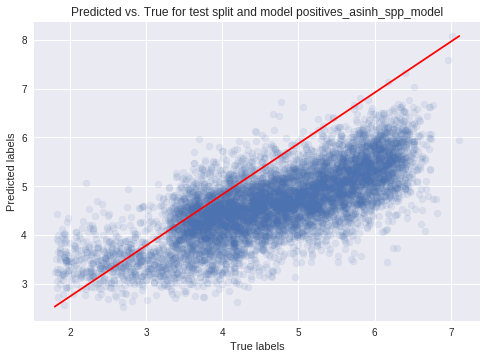

SpearmanrResult(correlation=0.7274216970044536, pvalue=0.0)
Model name binary_preact_model


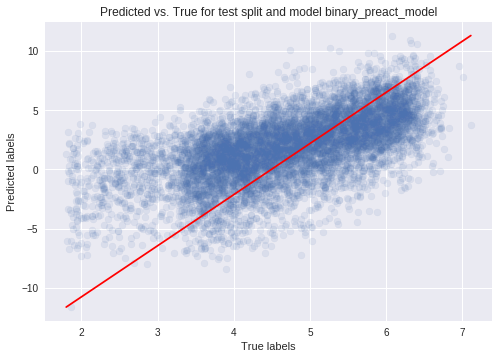

SpearmanrResult(correlation=0.6194997163935773, pvalue=0.0)
Split name valid
Model name positives_asinh_spp_model


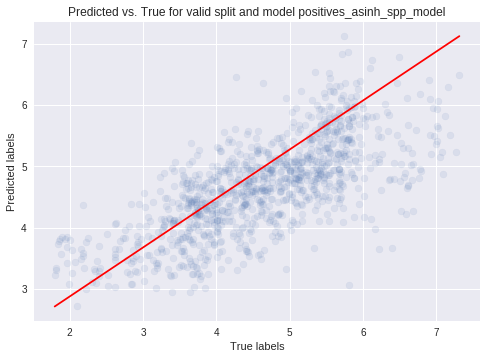

SpearmanrResult(correlation=0.7184702598656263, pvalue=1.770702032884338e-172)
Model name binary_preact_model


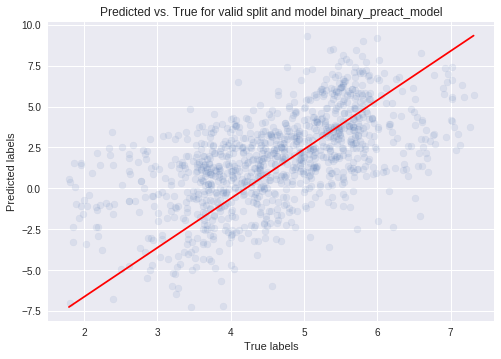

SpearmanrResult(correlation=0.6025823485038141, pvalue=6.322140010105187e-108)
Split name train
Model name positives_asinh_spp_model


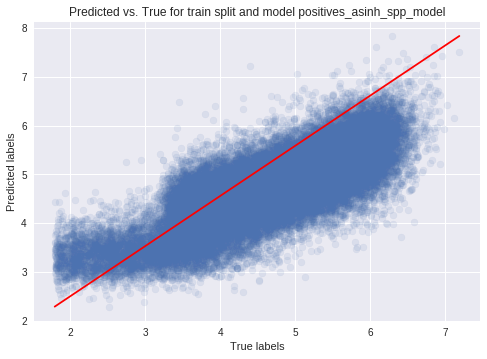

SpearmanrResult(correlation=0.7655613263221656, pvalue=0.0)
Model name binary_preact_model


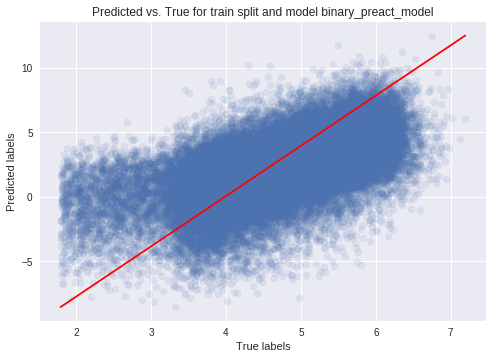

SpearmanrResult(correlation=0.5972833941121727, pvalue=0.0)


In [16]:
from scipy.stats import spearmanr
for split_name, split_labels, split_modelname_to_predictions in [
    ('test', test_positives_asinh_spp_y, test_positives_asinh_spp_name_to_predictions),
    ('valid', valid_positives_asinh_spp_y, valid_positives_asinh_spp_name_to_predictions),
    ('train', train_positives_asinh_spp_y, train_positives_asinh_spp_name_to_predictions)
]:
  print("Split name",split_name)
  for modelname in split_modelname_to_predictions:
    print("Model name",modelname)
    plt.scatter(split_labels[:,0],
                split_modelname_to_predictions[modelname][:,0], alpha=0.1)
    plt.xlabel("True labels")
    plt.ylabel("Predicted labels")
    plt.title("Predicted vs. True for "+split_name+" split"+" and model "+modelname)
    plt.plot([np.min(split_labels), np.max(split_labels)],
             [np.min(split_modelname_to_predictions[modelname][:,0]),
              np.max(split_modelname_to_predictions[modelname][:,0])],
             color="red")
    plt.show()
    print(spearmanr(a=split_labels[:,0],
                    b=split_modelname_to_predictions[modelname][:,0]))

In [18]:
from scipy.stats import spearmanr
from sklearn.metrics import roc_auc_score, average_precision_score

binary_name_to_model = {'positives_asinh_spp_model': positives_asinh_spp_model,
                        'binary_preact': binary_preact_model}

test_binary_y, test_binary_name_to_predictions = get_predictions_and_true_labels(
    bed_source="test_binary_labels.gz",
    name_to_model=binary_name_to_model)
valid_binary_y, valid_binary_name_to_predictions = get_predictions_and_true_labels(
    bed_source="valid_binary_labels.gz",
    name_to_model=binary_name_to_model)

for split_name, split_labels, split_modelname_to_predictions in [
    ('test', test_binary_y, test_binary_name_to_predictions),
    ('valid', valid_binary_y, valid_binary_name_to_predictions)]:
  print("\nSplit name",split_name)
  print("Proportion of positives:",np.sum(split_labels)/len(split_labels))
  print("auROC")
  for modelname in split_modelname_to_predictions:
    print(modelname,
      roc_auc_score(y_true=split_labels[:,0],
                    y_score=split_modelname_to_predictions[modelname][:,0]))
  print("auPRC")
  for modelname in split_modelname_to_predictions:
    print(modelname,
      average_precision_score(y_true=split_labels[:,0],
                              y_score=split_modelname_to_predictions[modelname][:,0]))





Reading bed file test_binary_labels.gz into memory
Finished reading bed file into memory; got 439596rows


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: generator 'get_pyfasta_generator' raised StopIteration
  import sys


Reading bed file valid_binary_labels.gz into memory
Finished reading bed file into memory; got 51900rows

Split name test
Proportion of positives: 0.01853065087034459
auROC
positives_asinh_spp_model 0.9133666997506424
binary_preact 0.9874525429226958
auPRC
positives_asinh_spp_model 0.6615521417124515
binary_preact 0.8078361060721013

Split name valid
Proportion of positives: 0.020847784200385355
auROC
positives_asinh_spp_model 0.9084512222916634
binary_preact 0.9822347613014121
auPRC
positives_asinh_spp_model 0.5798557228477231
binary_preact 0.7236613088568333


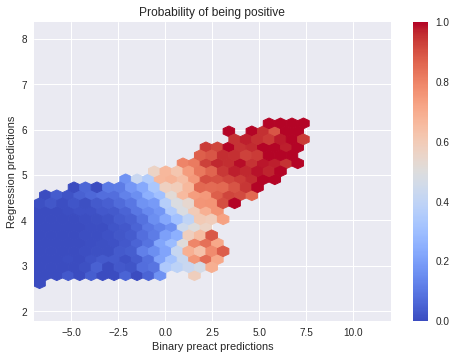

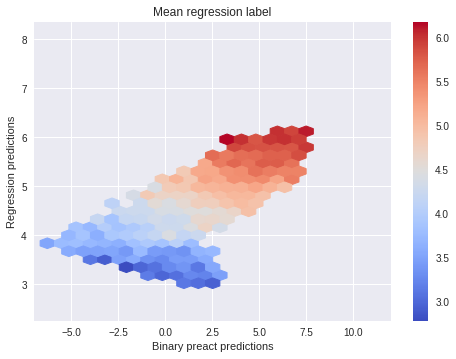

In [64]:
from matplotlib import pyplot as plt
import seaborn as sns

hb = plt.hexbin(test_binary_name_to_predictions['binary_preact'][test_binary_name_to_predictions['binary_preact'] > -7],
           test_binary_name_to_predictions['positives_asinh_spp_model'][test_binary_name_to_predictions['binary_preact'] > -7],
           C=test_binary_y[test_binary_name_to_predictions['binary_preact'] > -7],
           reduce_C_function=lambda x: np.sum(x)/len(x),
           mincnt=10,
           cmap="coolwarm",
           gridsize=30)
plt.colorbar(hb)
plt.xlim(-7,12)
plt.title("Probability of being positive")
plt.xlabel("Binary preact predictions")
plt.ylabel("Regression predictions")
plt.show()

hb = plt.hexbin(test_positives_asinh_spp_name_to_predictions['binary_preact_model'][:,0],
           test_positives_asinh_spp_name_to_predictions['positives_asinh_spp_model'][:,0],
           C=test_positives_asinh_spp_y[:,0],
           reduce_C_function=lambda x: np.mean(x),
           mincnt=10,
           cmap="coolwarm",
           gridsize=30)
plt.colorbar(hb)
plt.xlim(-7,12)
plt.title("Mean regression label")
plt.xlabel("Binary preact predictions")
plt.ylabel("Regression predictions")
plt.show()